# Article Page Views API Example
This example illustrates how to access page view data using the [Wikimedia REST API](https://www.mediawiki.org/wiki/Wikimedia_REST_API). This example shows how to request monthly counts of page views for one specific article. The API documentation, [pageviews/per-article](https://wikimedia.org/api/rest_v1/#/Pageviews%20data), covers additional details that may be helpful when trying to use or understand this example.

## License
This code example was developed by Dr. David W. McDonald for use in DATA 512, a course in the UW MS Data Science degree program. This code is provided under the [Creative Commons](https://creativecommons.org) [CC-BY license](https://creativecommons.org/licenses/by/4.0/). Revision 1.1 - May 5, 2022



In [2]:
# 
# These are standard python modules
import json, time, urllib.parse
#
# The 'requests' module is not a standard Python module. You will need to install this with pip/pip3 if you do not already have it
import requests
import pandas as pd

The example relies on some constants that help make the code a bit more readable.

In [5]:
#########
#
#    CONSTANTS
#

# The REST API 'pageviews' URL - this is the common URL/endpoint for all 'pageviews' API requests
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'

# This is a parameterized string that specifies what kind of pageviews request we are going to make
# In this case it will be a 'per-article' based request. The string is a format string so that we can
# replace each parameter with an appropriate value before making the request
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

# The Pageviews API asks that we not exceed 100 requests per second, we add a small delay to each request
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

# When making a request to the Wikimedia API they ask that you include a "unique ID" that will allow them to
# contact you if something happens - such as - your code exceeding request limits - or some other error happens
REQUEST_HEADERS = {
    'User-Agent': '<yangj98@uw.edu>, University of Washington, MSDS DATA 512 - AUTUMN 2022',
}

# This is just a list of English Wikipedia article titles that we can use for example requests
# ARTICLE_TITLES = [ 'Bison', 'Northern flicker', 'Red squirrel', 'Chinook salmon', 'Horseshoe bat' ]

#----Create the article titles ----
df = pd.read_csv("dinosaur_genera.cleaned.SEPT.2022 - dinosaur_genera.cleaned.SEPT.2022.csv")
ARTICLE_TITLES = df['name']


# This template is used to map parameter values into the API_REQUST_PER_ARTICLE_PARAMS portion of an API request. The dictionary has a
# field/key for each of the required parameters. In the example, below, we only vary the article name, so the majority of the fields
# can stay constant for each request. Of course, these values *could* be changed if necessary.
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "desktop",      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015010100",
    "end":         "2022093000"    # this is likely the wrong end date
}


The API request will be made using one procedure. The idea is to make this reusable. The procedure is parameterized, but relies on the constants above for the important parameters. The underlying assumption is that this will be used to request data for a set of article pages. Therefore the parameter most likely to change is the article_title.

In [6]:
#########
#
#    PROCEDURES/FUNCTIONS
#

def request_pageviews_per_article(article_title = None, 
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT, 
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS, 
                                  request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE,
                                  headers = REQUEST_HEADERS):
    # Make sure we have an article title
    if not article_title: return None
    
    # Titles are supposed to have spaces replaced with "_" and be URL encoded
    article_title_encoded = urllib.parse.quote(article_title.replace(' ','_'))
    request_template['article'] = article_title_encoded
    print("doing: ", request_template['article'])
    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)
    
    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

#-----Function that creates the dataframe for the associated access and article ----#

def create_dataframe(filename, ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE):
    output_df = pd.DataFrame()
    for i in range(1, len(ARTICLE_TITLES)):
        print("Getting pageview data for: ",ARTICLE_TITLES[i])
        print("Percentage done: ", i/len(ARTICLE_TITLES))
        views = request_pageviews_per_article(ARTICLE_TITLES[i], request_template= ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE)
        views_df = pd.DataFrame(views['items'])
        output_df = pd.concat([output_df, views_df])
    #     print(views_df)

    result = output_df.to_json(orient="records")
    parsed = json.loads(result)
    print(output_df)

    f = open(filename, 'w')
    f.write(json.dumps(parsed, indent=4))
    f.close()
    
    print("Wrote to file!")
    return output_df


In [284]:
#-------------STEP 1 -----------------

#--------- GET THE DESKTOP JSON FILE ------------#

ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "desktop",      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015010100",
    "end":         "2022093000"    # this is likely the wrong end date
}


df_desk = create_dataframe('dino_monthly_desktop_201501-202209.json', ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE)

Getting pageview data for:  Aachenosaurus
Percentage done:  0.0007027406886858749
doing:  Aachenosaurus
Getting pageview data for:  Aardonyx
Percentage done:  0.0014054813773717498
doing:  Aardonyx
Getting pageview data for:  Abdarainurus
Percentage done:  0.0021082220660576245
doing:  Abdarainurus
Getting pageview data for:  Abditosaurus
Percentage done:  0.0028109627547434997
doing:  Abditosaurus
Getting pageview data for:  Abelisaurus
Percentage done:  0.0035137034434293743
doing:  Abelisaurus
Getting pageview data for:  Abrictosaurus
Percentage done:  0.004216444132115249
doing:  Abrictosaurus
Getting pageview data for:  Abrosaurus
Percentage done:  0.004919184820801124
doing:  Abrosaurus
Getting pageview data for:  Abydosaurus
Percentage done:  0.005621925509486999
doing:  Abydosaurus
Getting pageview data for:  Acantholipan
Percentage done:  0.006324666198172874
doing:  Acantholipan
Getting pageview data for:  Acanthopholis
Percentage done:  0.007027406886858749
doing:  Acanthoph

Getting pageview data for:  Angolatitan
Percentage done:  0.059732958538299366
doing:  Angolatitan
Getting pageview data for:  Angulomastacator
Percentage done:  0.060435699226985246
doing:  Angulomastacator
Getting pageview data for:  Anhuilong
Percentage done:  0.06113843991567112
doing:  Anhuilong
Getting pageview data for:  Aniksosaurus
Percentage done:  0.06184118060435699
doing:  Aniksosaurus
Getting pageview data for:  Animantarx
Percentage done:  0.06254392129304287
doing:  Animantarx
Getting pageview data for:  Ankistrodon
Percentage done:  0.06324666198172874
doing:  Ankistrodon
Getting pageview data for:  Ankylosauria
Percentage done:  0.06394940267041462
doing:  Ankylosauria
Getting pageview data for:  Ankylosaurus
Percentage done:  0.0646521433591005
doing:  Ankylosaurus
Getting pageview data for:  Anodontosaurus
Percentage done:  0.06535488404778636
doing:  Anodontosaurus
Getting pageview data for:  Anomalipes
Percentage done:  0.06605762473647224
doing:  Anomalipes
Getti

Getting pageview data for:  Azendohsaurus
Percentage done:  0.11806043569922699
doing:  Azendohsaurus
Getting pageview data for:  Azhdarchoidea
Percentage done:  0.11876317638791287
doing:  Azhdarchoidea
Getting pageview data for:  Baalsaurus
Percentage done:  0.11946591707659873
doing:  Baalsaurus
Getting pageview data for:  Bactrosaurus
Percentage done:  0.12016865776528461
doing:  Bactrosaurus
Getting pageview data for:  Bagaceratops
Percentage done:  0.12087139845397049
doing:  Bagaceratops
Getting pageview data for:  Bagaraatan
Percentage done:  0.12157413914265636
doing:  Bagaraatan
Getting pageview data for:  Bagualia
Percentage done:  0.12227687983134224
doing:  Bagualia
Getting pageview data for:  Bagualosaurus
Percentage done:  0.12297962052002812
doing:  Bagualosaurus
Getting pageview data for:  Bahariasaurus
Percentage done:  0.12368236120871398
doing:  Bahariasaurus
Getting pageview data for:  Bainoceratops
Percentage done:  0.12438510189739986
doing:  Bainoceratops
Gettin

Getting pageview data for:  Camptosaurus
Percentage done:  0.17779339423752635
doing:  Camptosaurus
Getting pageview data for:  Campylodoniscus
Percentage done:  0.17849613492621222
doing:  Campylodoniscus
Getting pageview data for:  Canardia
Percentage done:  0.1791988756148981
doing:  Canardia
Getting pageview data for:  Carcharodontosaurus
Percentage done:  0.17990161630358398
doing:  Carcharodontosaurus
Getting pageview data for:  Cardiodon
Percentage done:  0.18060435699226984
doing:  Cardiodon
Getting pageview data for:  Carnotaurus
Percentage done:  0.18130709768095574
doing:  Carnotaurus
Getting pageview data for:  Caseosaurus
Percentage done:  0.1820098383696416
doing:  Caseosaurus
Getting pageview data for:  Cathartesaura
Percentage done:  0.18271257905832747
doing:  Cathartesaura
Getting pageview data for:  Caudipteryx
Percentage done:  0.18341531974701336
doing:  Caudipteryx
Getting pageview data for:  Cedarosaurus
Percentage done:  0.18411806043569923
doing:  Cedarosaurus


Getting pageview data for:  Cryptosaurus
Percentage done:  0.23612087139845397
doing:  Cryptosaurus
Getting pageview data for:  Cumnoria
Percentage done:  0.23682361208713984
doing:  Cumnoria
Getting pageview data for:  Daanosaurus
Percentage done:  0.23752635277582573
doing:  Daanosaurus
Getting pageview data for:  Dacentrurus
Percentage done:  0.2382290934645116
doing:  Dacentrurus
Getting pageview data for:  Daemonosaurus
Percentage done:  0.23893183415319746
doing:  Daemonosaurus
Getting pageview data for:  Dahalokely
Percentage done:  0.23963457484188336
doing:  Dahalokely
Getting pageview data for:  Dakosaurus
Percentage done:  0.24033731553056922
doing:  Dakosaurus
Getting pageview data for:  Dakotadon
Percentage done:  0.2410400562192551
doing:  Dakotadon
Getting pageview data for:  Dakotaraptor
Percentage done:  0.24174279690794098
doing:  Dakotaraptor
Getting pageview data for:  Daliansaurus
Percentage done:  0.24244553759662685
doing:  Daliansaurus
Getting pageview data for:

Getting pageview data for:  Enigmosaurus
Percentage done:  0.2951510892480675
doing:  Enigmosaurus
Getting pageview data for:  Eoabelisaurus
Percentage done:  0.29585382993675335
doing:  Eoabelisaurus
Getting pageview data for:  Eocarcharia
Percentage done:  0.2965565706254392
doing:  Eocarcharia
Getting pageview data for:  Eocursor
Percentage done:  0.2972593113141251
doing:  Eocursor
Getting pageview data for:  Eodromaeus
Percentage done:  0.29796205200281095
doing:  Eodromaeus
Getting pageview data for:  Eolambia
Percentage done:  0.2986647926914968
doing:  Eolambia
Getting pageview data for:  Eomamenchisaurus
Percentage done:  0.29936753338018274
doing:  Eomamenchisaurus
Getting pageview data for:  Eoraptor
Percentage done:  0.3000702740688686
doing:  Eoraptor
Getting pageview data for:  Eosinopteryx
Percentage done:  0.30077301475755447
doing:  Eosinopteryx
Getting pageview data for:  Eotrachodon
Percentage done:  0.30147575544624033
doing:  Eotrachodon
Getting pageview data for: 

Getting pageview data for:  Glishades
Percentage done:  0.354181307097681
doing:  Glishades
Getting pageview data for:  Glyptodontopelta
Percentage done:  0.35488404778636684
doing:  Glyptodontopelta
Getting pageview data for:  Gnathovorax
Percentage done:  0.3555867884750527
doing:  Gnathovorax
Getting pageview data for:  Gobihadros
Percentage done:  0.35628952916373857
doing:  Gobihadros
Getting pageview data for:  Gobiraptor
Percentage done:  0.35699226985242444
doing:  Gobiraptor
Getting pageview data for:  Gobisaurus
Percentage done:  0.3576950105411103
doing:  Gobisaurus
Getting pageview data for:  Gobititan
Percentage done:  0.3583977512297962
doing:  Gobititan
Getting pageview data for:  Gobivenator
Percentage done:  0.3591004919184821
doing:  Gobivenator
Getting pageview data for:  Gojirasaurus
Percentage done:  0.35980323260716796
doing:  Gojirasaurus
Getting pageview data for:  Gondwanatitan
Percentage done:  0.3605059732958538
doing:  Gondwanatitan
Getting pageview data for

Getting pageview data for:  Iberospinus
Percentage done:  0.41321152494729446
doing:  Iberospinus
Getting pageview data for:  Ichthyosaur
Percentage done:  0.4139142656359803
doing:  Ichthyosaur
Getting pageview data for:  Ichthyovenator
Percentage done:  0.4146170063246662
doing:  Ichthyovenator
Getting pageview data for:  Ignavusaurus
Percentage done:  0.41531974701335206
doing:  Ignavusaurus
Getting pageview data for:  Ignotosaurus
Percentage done:  0.4160224877020379
doing:  Ignotosaurus
Getting pageview data for:  Iguanacolossus
Percentage done:  0.41672522839072385
doing:  Iguanacolossus
Getting pageview data for:  Iguanodon
Percentage done:  0.4174279690794097
doing:  Iguanodon
Getting pageview data for:  Iliosuchus
Percentage done:  0.4181307097680956
doing:  Iliosuchus
Getting pageview data for:  Ilokelesia
Percentage done:  0.41883345045678144
doing:  Ilokelesia
Getting pageview data for:  Imperobator
Percentage done:  0.4195361911454673
doing:  Imperobator
Getting pageview d

Getting pageview data for:  Kulceratops
Percentage done:  0.4729444834855938
doing:  Kulceratops
Getting pageview data for:  Kulindadromeus
Percentage done:  0.4736472241742797
doing:  Kulindadromeus
Getting pageview data for:  Kunbarrasaurus
Percentage done:  0.47434996486296555
doing:  Kunbarrasaurus
Getting pageview data for:  Kundurosaurus
Percentage done:  0.47505270555165147
doing:  Kundurosaurus
Getting pageview data for:  Kuru kulla
Percentage done:  0.47575544624033733
doing:  Kuru_kulla
Getting pageview data for:  Kurupi itaata
Percentage done:  0.4764581869290232
doing:  Kurupi_itaata
Getting pageview data for:  Kuszholia
Percentage done:  0.47716092761770906
doing:  Kuszholia
Getting pageview data for:  Kwanasaurus
Percentage done:  0.47786366830639493
doing:  Kwanasaurus
Getting pageview data for:  Labocania
Percentage done:  0.4785664089950808
doing:  Labocania
Getting pageview data for:  Laevisuchus
Percentage done:  0.4792691496837667
doing:  Laevisuchus
Getting pagevie

Getting pageview data for:  Macelognathus
Percentage done:  0.5312719606465214
doing:  Macelognathus
Getting pageview data for:  Machairasaurus
Percentage done:  0.5319747013352073
doing:  Machairasaurus
Getting pageview data for:  Machairoceratops
Percentage done:  0.5326774420238932
doing:  Machairoceratops
Getting pageview data for:  Machimosaurus
Percentage done:  0.533380182712579
doing:  Machimosaurus
Getting pageview data for:  Macrocollum
Percentage done:  0.534082923401265
doing:  Macrocollum
Getting pageview data for:  Macrodontophion
Percentage done:  0.5347856640899508
doing:  Macrodontophion
Getting pageview data for:  Macrogryphosaurus
Percentage done:  0.5354884047786367
doing:  Macrogryphosaurus
Getting pageview data for:  Macrurosaurus
Percentage done:  0.5361911454673226
doing:  Macrurosaurus
Getting pageview data for:  Magnamanus
Percentage done:  0.5368938861560084
doing:  Magnamanus
Getting pageview data for:  Magnapaulia
Percentage done:  0.5375966268446943
doing:

Getting pageview data for:  Nanningosaurus
Percentage done:  0.5888966971187631
doing:  Nanningosaurus
Getting pageview data for:  Nanosaurus
Percentage done:  0.5895994378074491
doing:  Nanosaurus
Getting pageview data for:  Nanshiungosaurus
Percentage done:  0.590302178496135
doing:  Nanshiungosaurus
Getting pageview data for:  Nanuqsaurus
Percentage done:  0.5910049191848208
doing:  Nanuqsaurus
Getting pageview data for:  Nanyangosaurus
Percentage done:  0.5917076598735067
doing:  Nanyangosaurus
Getting pageview data for:  Napaisaurus
Percentage done:  0.5924104005621925
doing:  Napaisaurus
Getting pageview data for:  Narambuenatitan
Percentage done:  0.5931131412508784
doing:  Narambuenatitan
Getting pageview data for:  Narindasaurus
Percentage done:  0.5938158819395642
doing:  Narindasaurus
Getting pageview data for:  Nasutoceratops
Percentage done:  0.5945186226282502
doing:  Nasutoceratops
Getting pageview data for:  Navajoceratops
Percentage done:  0.5952213633169361
doing:  Na

Getting pageview data for:  Pachysuchus
Percentage done:  0.6472241742796908
doing:  Pachysuchus
Getting pageview data for:  Padillasaurus
Percentage done:  0.6479269149683766
doing:  Padillasaurus
Getting pageview data for:  Palaeoctonus
Percentage done:  0.6486296556570625
doing:  Palaeoctonus
Getting pageview data for:  Palaeocursornis
Percentage done:  0.6493323963457485
doing:  Palaeocursornis
Getting pageview data for:  Palaeopteryx
Percentage done:  0.6500351370344343
doing:  Palaeopteryx
Getting pageview data for:  Palaeosaurus
Percentage done:  0.6507378777231202
doing:  Palaeosaurus
Getting pageview data for:  Palaeoscincus
Percentage done:  0.651440618411806
doing:  Palaeoscincus
Getting pageview data for:  Paludititan
Percentage done:  0.6521433591004919
doing:  Paludititan
Getting pageview data for:  Pampadromaeus
Percentage done:  0.6528460997891778
doing:  Pampadromaeus
Getting pageview data for:  Pamparaptor
Percentage done:  0.6535488404778637
doing:  Pamparaptor
Getti

Getting pageview data for:  Proa valdearinnoensis
Percentage done:  0.7062543921293043
doing:  Proa_valdearinnoensis
Getting pageview data for:  Probactrosaurus
Percentage done:  0.7069571328179901
doing:  Probactrosaurus
Getting pageview data for:  Probrachylophosaurus
Percentage done:  0.707659873506676
doing:  Probrachylophosaurus
Getting pageview data for:  Proceratosaurus
Percentage done:  0.708362614195362
doing:  Proceratosaurus
Getting pageview data for:  Procompsognathus
Percentage done:  0.7090653548840478
doing:  Procompsognathus
Getting pageview data for:  Prodeinodon
Percentage done:  0.7097680955727337
doing:  Prodeinodon
Getting pageview data for:  Propanoplosaurus
Percentage done:  0.7104708362614195
doing:  Propanoplosaurus
Getting pageview data for:  Prosaurolophus
Percentage done:  0.7111735769501054
doing:  Prosaurolophus
Getting pageview data for:  Protarchaeopteryx
Percentage done:  0.7118763176387913
doing:  Protarchaeopteryx
Getting pageview data for:  Protecova

Getting pageview data for:  Sanxiasaurus
Percentage done:  0.7652846099789178
doing:  Sanxiasaurus
Getting pageview data for:  Sarahsaurus
Percentage done:  0.7659873506676037
doing:  Sarahsaurus
Getting pageview data for:  Sarcolestes
Percentage done:  0.7666900913562895
doing:  Sarcolestes
Getting pageview data for:  Sarcosaurus
Percentage done:  0.7673928320449754
doing:  Sarcosaurus
Getting pageview data for:  Sarmientosaurus
Percentage done:  0.7680955727336612
doing:  Sarmientosaurus
Getting pageview data for:  Saurolophus
Percentage done:  0.7687983134223472
doing:  Saurolophus
Getting pageview data for:  Sauroniops
Percentage done:  0.769501054111033
doing:  Sauroniops
Getting pageview data for:  Sauropelta
Percentage done:  0.7702037947997189
doing:  Sauropelta
Getting pageview data for:  Saurophaganax
Percentage done:  0.7709065354884048
doing:  Saurophaganax
Getting pageview data for:  Sauroplites
Percentage done:  0.7716092761770906
doing:  Sauroplites
Getting pageview data

Getting pageview data for:  Sphenosuchia
Percentage done:  0.8243148278285313
doing:  Sphenosuchia
Getting pageview data for:  Sphenosuchus
Percentage done:  0.8250175685172172
doing:  Sphenosuchus
Getting pageview data for:  Spiclypeus
Percentage done:  0.825720309205903
doing:  Spiclypeus
Getting pageview data for:  Spicomellus
Percentage done:  0.8264230498945889
doing:  Spicomellus
Getting pageview data for:  Spinophorosaurus
Percentage done:  0.8271257905832747
doing:  Spinophorosaurus
Getting pageview data for:  Spinops
Percentage done:  0.8278285312719607
doing:  Spinops
Getting pageview data for:  Spinosaurus
Percentage done:  0.8285312719606466
doing:  Spinosaurus
Getting pageview data for:  Spinostropheus
Percentage done:  0.8292340126493324
doing:  Spinostropheus
Getting pageview data for:  Spinosuchus
Percentage done:  0.8299367533380183
doing:  Spinosuchus
Getting pageview data for:  Spondylosoma
Percentage done:  0.8306394940267041
doing:  Spondylosoma
Getting pageview da

Getting pageview data for:  Therapsid
Percentage done:  0.8833450456781448
doing:  Therapsid
Getting pageview data for:  Therizinosaurus
Percentage done:  0.8840477863668307
doing:  Therizinosaurus
Getting pageview data for:  Theropoda
Percentage done:  0.8847505270555165
doing:  Theropoda
Getting pageview data for:  Thescelosaurus
Percentage done:  0.8854532677442024
doing:  Thescelosaurus
Getting pageview data for:  Thespesius
Percentage done:  0.8861560084328882
doing:  Thespesius
Getting pageview data for:  Tianchisaurus
Percentage done:  0.8868587491215741
doing:  Tianchisaurus
Getting pageview data for:  Tianyulong
Percentage done:  0.8875614898102601
doing:  Tianyulong
Getting pageview data for:  Tianyuraptor
Percentage done:  0.8882642304989459
doing:  Tianyuraptor
Getting pageview data for:  Tianzhenosaurus
Percentage done:  0.8889669711876318
doing:  Tianzhenosaurus
Getting pageview data for:  Tichosteus
Percentage done:  0.8896697118763176
doing:  Tichosteus
Getting pageview

Getting pageview data for:  Wannanosaurus
Percentage done:  0.9423752635277582
doing:  Wannanosaurus
Getting pageview data for:  Weewarrasaurus
Percentage done:  0.9430780042164442
doing:  Weewarrasaurus
Getting pageview data for:  Wellnhoferia
Percentage done:  0.94378074490513
doing:  Wellnhoferia
Getting pageview data for:  Wendiceratops
Percentage done:  0.9444834855938159
doing:  Wendiceratops
Getting pageview data for:  Wiehenvenator
Percentage done:  0.9451862262825017
doing:  Wiehenvenator
Getting pageview data for:  Willinakaqe
Percentage done:  0.9458889669711876
doing:  Willinakaqe
Getting pageview data for:  Wintonotitan
Percentage done:  0.9465917076598735
doing:  Wintonotitan
Getting pageview data for:  Wuerhosaurus
Percentage done:  0.9472944483485594
doing:  Wuerhosaurus
Getting pageview data for:  Wulagasaurus
Percentage done:  0.9479971890372453
doing:  Wulagasaurus
Getting pageview data for:  Wulatelong
Percentage done:  0.9486999297259311
doing:  Wulatelong
Getting 

Wrote to file!


In [9]:
#--------- GET THE MOBILE WEB JSON FILE ------------#

ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "mobile-web",      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015010100",
    "end":         "2022093000"    # this is likely the wrong end date
}


df_web = create_dataframe('dino_monthly_mobileweb_201501-202209.json', ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE)






Getting pageview data for:  Aachenosaurus
Percentage done:  0.0007027406886858749
doing:  Aachenosaurus
Getting pageview data for:  Aardonyx
Percentage done:  0.0014054813773717498
doing:  Aardonyx
Getting pageview data for:  Abdarainurus
Percentage done:  0.0021082220660576245
doing:  Abdarainurus
Getting pageview data for:  Abditosaurus
Percentage done:  0.0028109627547434997
doing:  Abditosaurus
Getting pageview data for:  Abelisaurus
Percentage done:  0.0035137034434293743
doing:  Abelisaurus
Getting pageview data for:  Abrictosaurus
Percentage done:  0.004216444132115249
doing:  Abrictosaurus
Getting pageview data for:  Abrosaurus
Percentage done:  0.004919184820801124
doing:  Abrosaurus
Getting pageview data for:  Abydosaurus
Percentage done:  0.005621925509486999
doing:  Abydosaurus
Getting pageview data for:  Acantholipan
Percentage done:  0.006324666198172874
doing:  Acantholipan
Getting pageview data for:  Acanthopholis
Percentage done:  0.007027406886858749
doing:  Acanthoph

Getting pageview data for:  Andesaurus
Percentage done:  0.059030217849613494
doing:  Andesaurus
Getting pageview data for:  Angolatitan
Percentage done:  0.059732958538299366
doing:  Angolatitan
Getting pageview data for:  Angulomastacator
Percentage done:  0.060435699226985246
doing:  Angulomastacator
Getting pageview data for:  Anhuilong
Percentage done:  0.06113843991567112
doing:  Anhuilong
Getting pageview data for:  Aniksosaurus
Percentage done:  0.06184118060435699
doing:  Aniksosaurus
Getting pageview data for:  Animantarx
Percentage done:  0.06254392129304287
doing:  Animantarx
Getting pageview data for:  Ankistrodon
Percentage done:  0.06324666198172874
doing:  Ankistrodon
Getting pageview data for:  Ankylosauria
Percentage done:  0.06394940267041462
doing:  Ankylosauria
Getting pageview data for:  Ankylosaurus
Percentage done:  0.0646521433591005
doing:  Ankylosaurus
Getting pageview data for:  Anodontosaurus
Percentage done:  0.06535488404778636
doing:  Anodontosaurus
Gett

Getting pageview data for:  Avisaurus
Percentage done:  0.11735769501054111
doing:  Avisaurus
Getting pageview data for:  Azendohsaurus
Percentage done:  0.11806043569922699
doing:  Azendohsaurus
Getting pageview data for:  Azhdarchoidea
Percentage done:  0.11876317638791287
doing:  Azhdarchoidea
Getting pageview data for:  Baalsaurus
Percentage done:  0.11946591707659873
doing:  Baalsaurus
Getting pageview data for:  Bactrosaurus
Percentage done:  0.12016865776528461
doing:  Bactrosaurus
Getting pageview data for:  Bagaceratops
Percentage done:  0.12087139845397049
doing:  Bagaceratops
Getting pageview data for:  Bagaraatan
Percentage done:  0.12157413914265636
doing:  Bagaraatan
Getting pageview data for:  Bagualia
Percentage done:  0.12227687983134224
doing:  Bagualia
Getting pageview data for:  Bagualosaurus
Percentage done:  0.12297962052002812
doing:  Bagualosaurus
Getting pageview data for:  Bahariasaurus
Percentage done:  0.12368236120871398
doing:  Bahariasaurus
Getting pagevi

Getting pageview data for:  Camarillasaurus
Percentage done:  0.17568517217146873
doing:  Camarillasaurus
Getting pageview data for:  Camelotia
Percentage done:  0.1763879128601546
doing:  Camelotia
Getting pageview data for:  Camposaurus
Percentage done:  0.1770906535488405
doing:  Camposaurus
Getting pageview data for:  Camptosaurus
Percentage done:  0.17779339423752635
doing:  Camptosaurus
Getting pageview data for:  Campylodoniscus
Percentage done:  0.17849613492621222
doing:  Campylodoniscus
Getting pageview data for:  Canardia
Percentage done:  0.1791988756148981
doing:  Canardia
Getting pageview data for:  Carcharodontosaurus
Percentage done:  0.17990161630358398
doing:  Carcharodontosaurus
Getting pageview data for:  Cardiodon
Percentage done:  0.18060435699226984
doing:  Cardiodon
Getting pageview data for:  Carnotaurus
Percentage done:  0.18130709768095574
doing:  Carnotaurus
Getting pageview data for:  Caseosaurus
Percentage done:  0.1820098383696416
doing:  Caseosaurus
Gett

Getting pageview data for:  Crosbysaurus
Percentage done:  0.23330990864371048
doing:  Crosbysaurus
Getting pageview data for:  Crurotarsi
Percentage done:  0.23401264933239635
doing:  Crurotarsi
Getting pageview data for:  Cruxicheiros
Percentage done:  0.23471539002108222
doing:  Cruxicheiros
Getting pageview data for:  Cryolophosaurus
Percentage done:  0.2354181307097681
doing:  Cryolophosaurus
Getting pageview data for:  Cryptosaurus
Percentage done:  0.23612087139845397
doing:  Cryptosaurus
Getting pageview data for:  Cumnoria
Percentage done:  0.23682361208713984
doing:  Cumnoria
Getting pageview data for:  Daanosaurus
Percentage done:  0.23752635277582573
doing:  Daanosaurus
Getting pageview data for:  Dacentrurus
Percentage done:  0.2382290934645116
doing:  Dacentrurus
Getting pageview data for:  Daemonosaurus
Percentage done:  0.23893183415319746
doing:  Daemonosaurus
Getting pageview data for:  Dahalokely
Percentage done:  0.23963457484188336
doing:  Dahalokely
Getting pagevi

Getting pageview data for:  Elmisaurus
Percentage done:  0.2916373858046381
doing:  Elmisaurus
Getting pageview data for:  Elopteryx
Percentage done:  0.29234012649332397
doing:  Elopteryx
Getting pageview data for:  Elrhazosaurus
Percentage done:  0.29304286718200984
doing:  Elrhazosaurus
Getting pageview data for:  Emausaurus
Percentage done:  0.2937456078706957
doing:  Emausaurus
Getting pageview data for:  Embasaurus
Percentage done:  0.29444834855938157
doing:  Embasaurus
Getting pageview data for:  Enigmosaurus
Percentage done:  0.2951510892480675
doing:  Enigmosaurus
Getting pageview data for:  Eoabelisaurus
Percentage done:  0.29585382993675335
doing:  Eoabelisaurus
Getting pageview data for:  Eocarcharia
Percentage done:  0.2965565706254392
doing:  Eocarcharia
Getting pageview data for:  Eocursor
Percentage done:  0.2972593113141251
doing:  Eocursor
Getting pageview data for:  Eodromaeus
Percentage done:  0.29796205200281095
doing:  Eodromaeus
Getting pageview data for:  Eolam

Getting pageview data for:  Gigantosaurus
Percentage done:  0.3499648629655657
doing:  Gigantosaurus
Getting pageview data for:  Gigantoscelus
Percentage done:  0.3506676036542516
doing:  Gigantoscelus
Getting pageview data for:  Gigantspinosaurus
Percentage done:  0.35137034434293746
doing:  Gigantspinosaurus
Getting pageview data for:  Gilmoreosaurus
Percentage done:  0.3520730850316233
doing:  Gilmoreosaurus
Getting pageview data for:  Giraffatitan
Percentage done:  0.3527758257203092
doing:  Giraffatitan
Getting pageview data for:  Glacialisaurus
Percentage done:  0.35347856640899505
doing:  Glacialisaurus
Getting pageview data for:  Glishades
Percentage done:  0.354181307097681
doing:  Glishades
Getting pageview data for:  Glyptodontopelta
Percentage done:  0.35488404778636684
doing:  Glyptodontopelta
Getting pageview data for:  Gnathovorax
Percentage done:  0.3555867884750527
doing:  Gnathovorax
Getting pageview data for:  Gobihadros
Percentage done:  0.35628952916373857
doing:  

Getting pageview data for:  Hypselorhachis
Percentage done:  0.40829234012649335
doing:  Hypselorhachis
Getting pageview data for:  Hypselosaurus
Percentage done:  0.4089950808151792
doing:  Hypselosaurus
Getting pageview data for:  Hypselospinus
Percentage done:  0.4096978215038651
doing:  Hypselospinus
Getting pageview data for:  Hypsibema
Percentage done:  0.41040056219255094
doing:  Hypsibema
Getting pageview data for:  Hypsibema missouriensis
Percentage done:  0.4111033028812368
doing:  Hypsibema_missouriensis
Getting pageview data for:  Hypsilophodon
Percentage done:  0.4118060435699227
doing:  Hypsilophodon
Getting pageview data for:  Hypsirhophus
Percentage done:  0.4125087842586086
doing:  Hypsirhophus
Getting pageview data for:  Iberospinus
Percentage done:  0.41321152494729446
doing:  Iberospinus
Getting pageview data for:  Ichthyosaur
Percentage done:  0.4139142656359803
doing:  Ichthyosaur
Getting pageview data for:  Ichthyovenator
Percentage done:  0.4146170063246662
doin

Getting pageview data for:  Koreanosaurus
Percentage done:  0.46732255797610683
doing:  Koreanosaurus
Getting pageview data for:  Koshisaurus
Percentage done:  0.4680252986647927
doing:  Koshisaurus
Getting pageview data for:  Kosmoceratops
Percentage done:  0.46872803935347856
doing:  Kosmoceratops
Getting pageview data for:  Kotasaurus
Percentage done:  0.46943078004216443
doing:  Kotasaurus
Getting pageview data for:  Koutalisaurus
Percentage done:  0.4701335207308503
doing:  Koutalisaurus
Getting pageview data for:  Kritosaurus
Percentage done:  0.4708362614195362
doing:  Kritosaurus
Getting pageview data for:  Kryptops
Percentage done:  0.4715390021082221
doing:  Kryptops
Getting pageview data for:  Krzyzanowskisaurus
Percentage done:  0.47224174279690795
doing:  Krzyzanowskisaurus
Getting pageview data for:  Kulceratops
Percentage done:  0.4729444834855938
doing:  Kulceratops
Getting pageview data for:  Kulindadromeus
Percentage done:  0.4736472241742797
doing:  Kulindadromeus
Ge

Getting pageview data for:  Luoyanggia
Percentage done:  0.5256500351370345
doing:  Luoyanggia
Getting pageview data for:  Lurdusaurus
Percentage done:  0.5263527758257203
doing:  Lurdusaurus
Getting pageview data for:  Lusitanosaurus
Percentage done:  0.5270555165144062
doing:  Lusitanosaurus
Getting pageview data for:  Lusotitan
Percentage done:  0.5277582572030921
doing:  Lusotitan
Getting pageview data for:  Lusovenator
Percentage done:  0.5284609978917779
doing:  Lusovenator
Getting pageview data for:  Lutungutali
Percentage done:  0.5291637385804638
doing:  Lutungutali
Getting pageview data for:  Lycorhinus
Percentage done:  0.5298664792691496
doing:  Lycorhinus
Getting pageview data for:  Lythronax
Percentage done:  0.5305692199578356
doing:  Lythronax
Getting pageview data for:  Macelognathus
Percentage done:  0.5312719606465214
doing:  Macelognathus
Getting pageview data for:  Machairasaurus
Percentage done:  0.5319747013352073
doing:  Machairasaurus
Getting pageview data for:

Getting pageview data for:  Murusraptor
Percentage done:  0.5832747716092762
doing:  Murusraptor
Getting pageview data for:  Mussaurus
Percentage done:  0.583977512297962
doing:  Mussaurus
Getting pageview data for:  Muttaburrasaurus
Percentage done:  0.5846802529866479
doing:  Muttaburrasaurus
Getting pageview data for:  Muyelensaurus
Percentage done:  0.5853829936753338
doing:  Muyelensaurus
Getting pageview data for:  Mymoorapelta
Percentage done:  0.5860857343640197
doing:  Mymoorapelta
Getting pageview data for:  Naashoibitosaurus
Percentage done:  0.5867884750527056
doing:  Naashoibitosaurus
Getting pageview data for:  Nambalia
Percentage done:  0.5874912157413914
doing:  Nambalia
Getting pageview data for:  Nankangia
Percentage done:  0.5881939564300773
doing:  Nankangia
Getting pageview data for:  Nanningosaurus
Percentage done:  0.5888966971187631
doing:  Nanningosaurus
Getting pageview data for:  Nanosaurus
Percentage done:  0.5895994378074491
doing:  Nanosaurus
Getting pagev

Getting pageview data for:  Overoraptor
Percentage done:  0.6416022487702038
doing:  Overoraptor
Getting pageview data for:  Overosaurus
Percentage done:  0.6423049894588897
doing:  Overosaurus
Getting pageview data for:  Oviraptor
Percentage done:  0.6430077301475755
doing:  Oviraptor
Getting pageview data for:  Owenodon
Percentage done:  0.6437104708362614
doing:  Owenodon
Getting pageview data for:  Oxalaia
Percentage done:  0.6444132115249473
doing:  Oxalaia
Getting pageview data for:  Ozraptor
Percentage done:  0.6451159522136332
doing:  Ozraptor
Getting pageview data for:  Pachycephalosaurus
Percentage done:  0.6458186929023191
doing:  Pachycephalosaurus
Getting pageview data for:  Pachyrhinosaurus
Percentage done:  0.6465214335910049
doing:  Pachyrhinosaurus
Getting pageview data for:  Pachysuchus
Percentage done:  0.6472241742796908
doing:  Pachysuchus
Getting pageview data for:  Padillasaurus
Percentage done:  0.6479269149683766
doing:  Padillasaurus
Getting pageview data for:

Getting pageview data for:  Poposaurus
Percentage done:  0.6999297259311315
doing:  Poposaurus
Getting pageview data for:  Portellsaurus
Percentage done:  0.7006324666198173
doing:  Portellsaurus
Getting pageview data for:  Postosuchus
Percentage done:  0.7013352073085032
doing:  Postosuchus
Getting pageview data for:  Powellvenator
Percentage done:  0.702037947997189
doing:  Powellvenator
Getting pageview data for:  Pradhania
Percentage done:  0.7027406886858749
doing:  Pradhania
Getting pageview data for:  Prenocephale
Percentage done:  0.7034434293745608
doing:  Prenocephale
Getting pageview data for:  Prenoceratops
Percentage done:  0.7041461700632466
doing:  Prenoceratops
Getting pageview data for:  Priconodon
Percentage done:  0.7048489107519326
doing:  Priconodon
Getting pageview data for:  Priodontognathus
Percentage done:  0.7055516514406184
doing:  Priodontognathus
Getting pageview data for:  Proa valdearinnoensis
Percentage done:  0.7062543921293043
doing:  Proa_valdearinnoe

Getting pageview data for:  Ruyangosaurus
Percentage done:  0.758257203092059
doing:  Ruyangosaurus
Getting pageview data for:  Sacisaurus
Percentage done:  0.7589599437807449
doing:  Sacisaurus
Getting pageview data for:  Sahaliyania
Percentage done:  0.7596626844694307
doing:  Sahaliyania
Getting pageview data for:  Saichania
Percentage done:  0.7603654251581167
doing:  Saichania
Getting pageview data for:  Saltasaurus
Percentage done:  0.7610681658468025
doing:  Saltasaurus
Getting pageview data for:  Saltopus
Percentage done:  0.7617709065354884
doing:  Saltopus
Getting pageview data for:  Saltriovenator
Percentage done:  0.7624736472241743
doing:  Saltriovenator
Getting pageview data for:  Sanjuansaurus
Percentage done:  0.7631763879128601
doing:  Sanjuansaurus
Getting pageview data for:  Sanpasaurus
Percentage done:  0.763879128601546
doing:  Sanpasaurus
Getting pageview data for:  Santanaraptor
Percentage done:  0.7645818692902319
doing:  Santanaraptor
Getting pageview data for:

Getting pageview data for:  Sinusonasus
Percentage done:  0.8165846802529867
doing:  Sinusonasus
Getting pageview data for:  Sirindhorna
Percentage done:  0.8172874209416725
doing:  Sirindhorna
Getting pageview data for:  Skorpiovenator
Percentage done:  0.8179901616303584
doing:  Skorpiovenator
Getting pageview data for:  Smitanosaurus
Percentage done:  0.8186929023190442
doing:  Smitanosaurus
Getting pageview data for:  Sonidosaurus
Percentage done:  0.8193956430077302
doing:  Sonidosaurus
Getting pageview data for:  Sonorasaurus
Percentage done:  0.8200983836964161
doing:  Sonorasaurus
Getting pageview data for:  Soriatitan
Percentage done:  0.8208011243851019
doing:  Soriatitan
Getting pageview data for:  Soumyasaurus
Percentage done:  0.8215038650737878
doing:  Soumyasaurus
Getting pageview data for:  Spectrovenator
Percentage done:  0.8222066057624736
doing:  Spectrovenator
Getting pageview data for:  Sphaerotholus
Percentage done:  0.8229093464511595
doing:  Sphaerotholus
Gettin

Getting pageview data for:  Teratosaurus
Percentage done:  0.8749121574139143
doing:  Teratosaurus
Getting pageview data for:  Termatosaurus
Percentage done:  0.8756148981026002
doing:  Termatosaurus
Getting pageview data for:  Terminocavus
Percentage done:  0.876317638791286
doing:  Terminocavus
Getting pageview data for:  Tethyshadros
Percentage done:  0.8770203794799719
doing:  Tethyshadros
Getting pageview data for:  Texacephale
Percentage done:  0.8777231201686577
doing:  Texacephale
Getting pageview data for:  Texasetes
Percentage done:  0.8784258608573436
doing:  Texasetes
Getting pageview data for:  Thanatotheristes
Percentage done:  0.8791286015460296
doing:  Thanatotheristes
Getting pageview data for:  Thanos simonattoi
Percentage done:  0.8798313422347154
doing:  Thanos_simonattoi
Getting pageview data for:  Thecocoelurus
Percentage done:  0.8805340829234013
doing:  Thecocoelurus
Getting pageview data for:  Thecodontosaurus
Percentage done:  0.8812368236120871
doing:  Thecod

Getting pageview data for:  Venaticosuchus
Percentage done:  0.9339423752635277
doing:  Venaticosuchus
Getting pageview data for:  Venenosaurus
Percentage done:  0.9346451159522137
doing:  Venenosaurus
Getting pageview data for:  Vespersaurus
Percentage done:  0.9353478566408995
doing:  Vespersaurus
Getting pageview data for:  Veterupristisaurus
Percentage done:  0.9360505973295854
doing:  Veterupristisaurus
Getting pageview data for:  Viavenator
Percentage done:  0.9367533380182712
doing:  Viavenator
Getting pageview data for:  Volgatitan
Percentage done:  0.9374560787069571
doing:  Volgatitan
Getting pageview data for:  Volkheimeria
Percentage done:  0.938158819395643
doing:  Volkheimeria
Getting pageview data for:  Vouivria
Percentage done:  0.9388615600843289
doing:  Vouivria
Getting pageview data for:  Vulcanodon
Percentage done:  0.9395643007730148
doing:  Vulcanodon
Getting pageview data for:  Wakinosaurus
Percentage done:  0.9402670414617006
doing:  Wakinosaurus
Getting pagevie

Getting pageview data for:  Zhuchengtitan
Percentage done:  0.9929725931131412
doing:  Zhuchengtitan
Getting pageview data for:  Zhuchengtyrannus
Percentage done:  0.9936753338018272
doing:  Zhuchengtyrannus
Getting pageview data for:  Ziapelta
Percentage done:  0.994378074490513
doing:  Ziapelta
Getting pageview data for:  Zigongosaurus
Percentage done:  0.9950808151791989
doing:  Zigongosaurus
Getting pageview data for:  Zizhongosaurus
Percentage done:  0.9957835558678847
doing:  Zizhongosaurus
Getting pageview data for:  Zuniceratops
Percentage done:  0.9964862965565706
doing:  Zuniceratops
Getting pageview data for:  Zuolong
Percentage done:  0.9971890372452565
doing:  Zuolong
Getting pageview data for:  Zuoyunlong
Percentage done:  0.9978917779339423
doing:  Zuoyunlong
Getting pageview data for:  Zupaysaurus
Percentage done:  0.9985945186226283
doing:  Zupaysaurus
Getting pageview data for:  Zuul
Percentage done:  0.9992972593113141
doing:  Zuul
         project        article gra

In [10]:
#--------- GET THE MOBILE APP JSON FILE ------------#

ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "mobile-app",      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015010100",
    "end":         "2022093000"    # this is likely the wrong end date
}

df_app = create_dataframe('dino_monthly_mobileapp_201501-202209.json', ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE)

Getting pageview data for:  Aachenosaurus
Percentage done:  0.0007027406886858749
doing:  Aachenosaurus
Getting pageview data for:  Aardonyx
Percentage done:  0.0014054813773717498
doing:  Aardonyx
Getting pageview data for:  Abdarainurus
Percentage done:  0.0021082220660576245
doing:  Abdarainurus
Getting pageview data for:  Abditosaurus
Percentage done:  0.0028109627547434997
doing:  Abditosaurus
Getting pageview data for:  Abelisaurus
Percentage done:  0.0035137034434293743
doing:  Abelisaurus
Getting pageview data for:  Abrictosaurus
Percentage done:  0.004216444132115249
doing:  Abrictosaurus
Getting pageview data for:  Abrosaurus
Percentage done:  0.004919184820801124
doing:  Abrosaurus
Getting pageview data for:  Abydosaurus
Percentage done:  0.005621925509486999
doing:  Abydosaurus
Getting pageview data for:  Acantholipan
Percentage done:  0.006324666198172874
doing:  Acantholipan
Getting pageview data for:  Acanthopholis
Percentage done:  0.007027406886858749
doing:  Acanthoph

Getting pageview data for:  Andesaurus
Percentage done:  0.059030217849613494
doing:  Andesaurus
Getting pageview data for:  Angolatitan
Percentage done:  0.059732958538299366
doing:  Angolatitan
Getting pageview data for:  Angulomastacator
Percentage done:  0.060435699226985246
doing:  Angulomastacator
Getting pageview data for:  Anhuilong
Percentage done:  0.06113843991567112
doing:  Anhuilong
Getting pageview data for:  Aniksosaurus
Percentage done:  0.06184118060435699
doing:  Aniksosaurus
Getting pageview data for:  Animantarx
Percentage done:  0.06254392129304287
doing:  Animantarx
Getting pageview data for:  Ankistrodon
Percentage done:  0.06324666198172874
doing:  Ankistrodon
Getting pageview data for:  Ankylosauria
Percentage done:  0.06394940267041462
doing:  Ankylosauria
Getting pageview data for:  Ankylosaurus
Percentage done:  0.0646521433591005
doing:  Ankylosaurus
Getting pageview data for:  Anodontosaurus
Percentage done:  0.06535488404778636
doing:  Anodontosaurus
Gett

Getting pageview data for:  Avisaurus
Percentage done:  0.11735769501054111
doing:  Avisaurus
Getting pageview data for:  Azendohsaurus
Percentage done:  0.11806043569922699
doing:  Azendohsaurus
Getting pageview data for:  Azhdarchoidea
Percentage done:  0.11876317638791287
doing:  Azhdarchoidea
Getting pageview data for:  Baalsaurus
Percentage done:  0.11946591707659873
doing:  Baalsaurus
Getting pageview data for:  Bactrosaurus
Percentage done:  0.12016865776528461
doing:  Bactrosaurus
Getting pageview data for:  Bagaceratops
Percentage done:  0.12087139845397049
doing:  Bagaceratops
Getting pageview data for:  Bagaraatan
Percentage done:  0.12157413914265636
doing:  Bagaraatan
Getting pageview data for:  Bagualia
Percentage done:  0.12227687983134224
doing:  Bagualia
Getting pageview data for:  Bagualosaurus
Percentage done:  0.12297962052002812
doing:  Bagualosaurus
Getting pageview data for:  Bahariasaurus
Percentage done:  0.12368236120871398
doing:  Bahariasaurus
Getting pagevi

Getting pageview data for:  Camarillasaurus
Percentage done:  0.17568517217146873
doing:  Camarillasaurus
Getting pageview data for:  Camelotia
Percentage done:  0.1763879128601546
doing:  Camelotia
Getting pageview data for:  Camposaurus
Percentage done:  0.1770906535488405
doing:  Camposaurus
Getting pageview data for:  Camptosaurus
Percentage done:  0.17779339423752635
doing:  Camptosaurus
Getting pageview data for:  Campylodoniscus
Percentage done:  0.17849613492621222
doing:  Campylodoniscus
Getting pageview data for:  Canardia
Percentage done:  0.1791988756148981
doing:  Canardia
Getting pageview data for:  Carcharodontosaurus
Percentage done:  0.17990161630358398
doing:  Carcharodontosaurus
Getting pageview data for:  Cardiodon
Percentage done:  0.18060435699226984
doing:  Cardiodon
Getting pageview data for:  Carnotaurus
Percentage done:  0.18130709768095574
doing:  Carnotaurus
Getting pageview data for:  Caseosaurus
Percentage done:  0.1820098383696416
doing:  Caseosaurus
Gett

Getting pageview data for:  Crosbysaurus
Percentage done:  0.23330990864371048
doing:  Crosbysaurus
Getting pageview data for:  Crurotarsi
Percentage done:  0.23401264933239635
doing:  Crurotarsi
Getting pageview data for:  Cruxicheiros
Percentage done:  0.23471539002108222
doing:  Cruxicheiros
Getting pageview data for:  Cryolophosaurus
Percentage done:  0.2354181307097681
doing:  Cryolophosaurus
Getting pageview data for:  Cryptosaurus
Percentage done:  0.23612087139845397
doing:  Cryptosaurus
Getting pageview data for:  Cumnoria
Percentage done:  0.23682361208713984
doing:  Cumnoria
Getting pageview data for:  Daanosaurus
Percentage done:  0.23752635277582573
doing:  Daanosaurus
Getting pageview data for:  Dacentrurus
Percentage done:  0.2382290934645116
doing:  Dacentrurus
Getting pageview data for:  Daemonosaurus
Percentage done:  0.23893183415319746
doing:  Daemonosaurus
Getting pageview data for:  Dahalokely
Percentage done:  0.23963457484188336
doing:  Dahalokely
Getting pagevi

Getting pageview data for:  Elmisaurus
Percentage done:  0.2916373858046381
doing:  Elmisaurus
Getting pageview data for:  Elopteryx
Percentage done:  0.29234012649332397
doing:  Elopteryx
Getting pageview data for:  Elrhazosaurus
Percentage done:  0.29304286718200984
doing:  Elrhazosaurus
Getting pageview data for:  Emausaurus
Percentage done:  0.2937456078706957
doing:  Emausaurus
Getting pageview data for:  Embasaurus
Percentage done:  0.29444834855938157
doing:  Embasaurus
Getting pageview data for:  Enigmosaurus
Percentage done:  0.2951510892480675
doing:  Enigmosaurus
Getting pageview data for:  Eoabelisaurus
Percentage done:  0.29585382993675335
doing:  Eoabelisaurus
Getting pageview data for:  Eocarcharia
Percentage done:  0.2965565706254392
doing:  Eocarcharia
Getting pageview data for:  Eocursor
Percentage done:  0.2972593113141251
doing:  Eocursor
Getting pageview data for:  Eodromaeus
Percentage done:  0.29796205200281095
doing:  Eodromaeus
Getting pageview data for:  Eolam

Getting pageview data for:  Gigantosaurus
Percentage done:  0.3499648629655657
doing:  Gigantosaurus
Getting pageview data for:  Gigantoscelus
Percentage done:  0.3506676036542516
doing:  Gigantoscelus
Getting pageview data for:  Gigantspinosaurus
Percentage done:  0.35137034434293746
doing:  Gigantspinosaurus
Getting pageview data for:  Gilmoreosaurus
Percentage done:  0.3520730850316233
doing:  Gilmoreosaurus
Getting pageview data for:  Giraffatitan
Percentage done:  0.3527758257203092
doing:  Giraffatitan
Getting pageview data for:  Glacialisaurus
Percentage done:  0.35347856640899505
doing:  Glacialisaurus
Getting pageview data for:  Glishades
Percentage done:  0.354181307097681
doing:  Glishades
Getting pageview data for:  Glyptodontopelta
Percentage done:  0.35488404778636684
doing:  Glyptodontopelta
Getting pageview data for:  Gnathovorax
Percentage done:  0.3555867884750527
doing:  Gnathovorax
Getting pageview data for:  Gobihadros
Percentage done:  0.35628952916373857
doing:  

Getting pageview data for:  Hypselorhachis
Percentage done:  0.40829234012649335
doing:  Hypselorhachis
Getting pageview data for:  Hypselosaurus
Percentage done:  0.4089950808151792
doing:  Hypselosaurus
Getting pageview data for:  Hypselospinus
Percentage done:  0.4096978215038651
doing:  Hypselospinus
Getting pageview data for:  Hypsibema
Percentage done:  0.41040056219255094
doing:  Hypsibema
Getting pageview data for:  Hypsibema missouriensis
Percentage done:  0.4111033028812368
doing:  Hypsibema_missouriensis
Getting pageview data for:  Hypsilophodon
Percentage done:  0.4118060435699227
doing:  Hypsilophodon
Getting pageview data for:  Hypsirhophus
Percentage done:  0.4125087842586086
doing:  Hypsirhophus
Getting pageview data for:  Iberospinus
Percentage done:  0.41321152494729446
doing:  Iberospinus
Getting pageview data for:  Ichthyosaur
Percentage done:  0.4139142656359803
doing:  Ichthyosaur
Getting pageview data for:  Ichthyovenator
Percentage done:  0.4146170063246662
doin

Getting pageview data for:  Koreanosaurus
Percentage done:  0.46732255797610683
doing:  Koreanosaurus
Getting pageview data for:  Koshisaurus
Percentage done:  0.4680252986647927
doing:  Koshisaurus
Getting pageview data for:  Kosmoceratops
Percentage done:  0.46872803935347856
doing:  Kosmoceratops
Getting pageview data for:  Kotasaurus
Percentage done:  0.46943078004216443
doing:  Kotasaurus
Getting pageview data for:  Koutalisaurus
Percentage done:  0.4701335207308503
doing:  Koutalisaurus
Getting pageview data for:  Kritosaurus
Percentage done:  0.4708362614195362
doing:  Kritosaurus
Getting pageview data for:  Kryptops
Percentage done:  0.4715390021082221
doing:  Kryptops
Getting pageview data for:  Krzyzanowskisaurus
Percentage done:  0.47224174279690795
doing:  Krzyzanowskisaurus
Getting pageview data for:  Kulceratops
Percentage done:  0.4729444834855938
doing:  Kulceratops
Getting pageview data for:  Kulindadromeus
Percentage done:  0.4736472241742797
doing:  Kulindadromeus
Ge

Getting pageview data for:  Luoyanggia
Percentage done:  0.5256500351370345
doing:  Luoyanggia
Getting pageview data for:  Lurdusaurus
Percentage done:  0.5263527758257203
doing:  Lurdusaurus
Getting pageview data for:  Lusitanosaurus
Percentage done:  0.5270555165144062
doing:  Lusitanosaurus
Getting pageview data for:  Lusotitan
Percentage done:  0.5277582572030921
doing:  Lusotitan
Getting pageview data for:  Lusovenator
Percentage done:  0.5284609978917779
doing:  Lusovenator
Getting pageview data for:  Lutungutali
Percentage done:  0.5291637385804638
doing:  Lutungutali
Getting pageview data for:  Lycorhinus
Percentage done:  0.5298664792691496
doing:  Lycorhinus
Getting pageview data for:  Lythronax
Percentage done:  0.5305692199578356
doing:  Lythronax
Getting pageview data for:  Macelognathus
Percentage done:  0.5312719606465214
doing:  Macelognathus
Getting pageview data for:  Machairasaurus
Percentage done:  0.5319747013352073
doing:  Machairasaurus
Getting pageview data for:

Getting pageview data for:  Murusraptor
Percentage done:  0.5832747716092762
doing:  Murusraptor
Getting pageview data for:  Mussaurus
Percentage done:  0.583977512297962
doing:  Mussaurus
Getting pageview data for:  Muttaburrasaurus
Percentage done:  0.5846802529866479
doing:  Muttaburrasaurus
Getting pageview data for:  Muyelensaurus
Percentage done:  0.5853829936753338
doing:  Muyelensaurus
Getting pageview data for:  Mymoorapelta
Percentage done:  0.5860857343640197
doing:  Mymoorapelta
Getting pageview data for:  Naashoibitosaurus
Percentage done:  0.5867884750527056
doing:  Naashoibitosaurus
Getting pageview data for:  Nambalia
Percentage done:  0.5874912157413914
doing:  Nambalia
Getting pageview data for:  Nankangia
Percentage done:  0.5881939564300773
doing:  Nankangia
Getting pageview data for:  Nanningosaurus
Percentage done:  0.5888966971187631
doing:  Nanningosaurus
Getting pageview data for:  Nanosaurus
Percentage done:  0.5895994378074491
doing:  Nanosaurus
Getting pagev

Getting pageview data for:  Overoraptor
Percentage done:  0.6416022487702038
doing:  Overoraptor
Getting pageview data for:  Overosaurus
Percentage done:  0.6423049894588897
doing:  Overosaurus
Getting pageview data for:  Oviraptor
Percentage done:  0.6430077301475755
doing:  Oviraptor
Getting pageview data for:  Owenodon
Percentage done:  0.6437104708362614
doing:  Owenodon
Getting pageview data for:  Oxalaia
Percentage done:  0.6444132115249473
doing:  Oxalaia
Getting pageview data for:  Ozraptor
Percentage done:  0.6451159522136332
doing:  Ozraptor
Getting pageview data for:  Pachycephalosaurus
Percentage done:  0.6458186929023191
doing:  Pachycephalosaurus
Getting pageview data for:  Pachyrhinosaurus
Percentage done:  0.6465214335910049
doing:  Pachyrhinosaurus
Getting pageview data for:  Pachysuchus
Percentage done:  0.6472241742796908
doing:  Pachysuchus
Getting pageview data for:  Padillasaurus
Percentage done:  0.6479269149683766
doing:  Padillasaurus
Getting pageview data for:

Getting pageview data for:  Poposaurus
Percentage done:  0.6999297259311315
doing:  Poposaurus
Getting pageview data for:  Portellsaurus
Percentage done:  0.7006324666198173
doing:  Portellsaurus
Getting pageview data for:  Postosuchus
Percentage done:  0.7013352073085032
doing:  Postosuchus
Getting pageview data for:  Powellvenator
Percentage done:  0.702037947997189
doing:  Powellvenator
Getting pageview data for:  Pradhania
Percentage done:  0.7027406886858749
doing:  Pradhania
Getting pageview data for:  Prenocephale
Percentage done:  0.7034434293745608
doing:  Prenocephale
Getting pageview data for:  Prenoceratops
Percentage done:  0.7041461700632466
doing:  Prenoceratops
Getting pageview data for:  Priconodon
Percentage done:  0.7048489107519326
doing:  Priconodon
Getting pageview data for:  Priodontognathus
Percentage done:  0.7055516514406184
doing:  Priodontognathus
Getting pageview data for:  Proa valdearinnoensis
Percentage done:  0.7062543921293043
doing:  Proa_valdearinnoe

Getting pageview data for:  Ruyangosaurus
Percentage done:  0.758257203092059
doing:  Ruyangosaurus
Getting pageview data for:  Sacisaurus
Percentage done:  0.7589599437807449
doing:  Sacisaurus
Getting pageview data for:  Sahaliyania
Percentage done:  0.7596626844694307
doing:  Sahaliyania
Getting pageview data for:  Saichania
Percentage done:  0.7603654251581167
doing:  Saichania
Getting pageview data for:  Saltasaurus
Percentage done:  0.7610681658468025
doing:  Saltasaurus
Getting pageview data for:  Saltopus
Percentage done:  0.7617709065354884
doing:  Saltopus
Getting pageview data for:  Saltriovenator
Percentage done:  0.7624736472241743
doing:  Saltriovenator
Getting pageview data for:  Sanjuansaurus
Percentage done:  0.7631763879128601
doing:  Sanjuansaurus
Getting pageview data for:  Sanpasaurus
Percentage done:  0.763879128601546
doing:  Sanpasaurus
Getting pageview data for:  Santanaraptor
Percentage done:  0.7645818692902319
doing:  Santanaraptor
Getting pageview data for:

Getting pageview data for:  Sinusonasus
Percentage done:  0.8165846802529867
doing:  Sinusonasus
Getting pageview data for:  Sirindhorna
Percentage done:  0.8172874209416725
doing:  Sirindhorna
Getting pageview data for:  Skorpiovenator
Percentage done:  0.8179901616303584
doing:  Skorpiovenator
Getting pageview data for:  Smitanosaurus
Percentage done:  0.8186929023190442
doing:  Smitanosaurus
Getting pageview data for:  Sonidosaurus
Percentage done:  0.8193956430077302
doing:  Sonidosaurus
Getting pageview data for:  Sonorasaurus
Percentage done:  0.8200983836964161
doing:  Sonorasaurus
Getting pageview data for:  Soriatitan
Percentage done:  0.8208011243851019
doing:  Soriatitan
Getting pageview data for:  Soumyasaurus
Percentage done:  0.8215038650737878
doing:  Soumyasaurus
Getting pageview data for:  Spectrovenator
Percentage done:  0.8222066057624736
doing:  Spectrovenator
Getting pageview data for:  Sphaerotholus
Percentage done:  0.8229093464511595
doing:  Sphaerotholus
Gettin

Getting pageview data for:  Teratosaurus
Percentage done:  0.8749121574139143
doing:  Teratosaurus
Getting pageview data for:  Termatosaurus
Percentage done:  0.8756148981026002
doing:  Termatosaurus
Getting pageview data for:  Terminocavus
Percentage done:  0.876317638791286
doing:  Terminocavus
Getting pageview data for:  Tethyshadros
Percentage done:  0.8770203794799719
doing:  Tethyshadros
Getting pageview data for:  Texacephale
Percentage done:  0.8777231201686577
doing:  Texacephale
Getting pageview data for:  Texasetes
Percentage done:  0.8784258608573436
doing:  Texasetes
Getting pageview data for:  Thanatotheristes
Percentage done:  0.8791286015460296
doing:  Thanatotheristes
Getting pageview data for:  Thanos simonattoi
Percentage done:  0.8798313422347154
doing:  Thanos_simonattoi
Getting pageview data for:  Thecocoelurus
Percentage done:  0.8805340829234013
doing:  Thecocoelurus
Getting pageview data for:  Thecodontosaurus
Percentage done:  0.8812368236120871
doing:  Thecod

Getting pageview data for:  Venaticosuchus
Percentage done:  0.9339423752635277
doing:  Venaticosuchus
Getting pageview data for:  Venenosaurus
Percentage done:  0.9346451159522137
doing:  Venenosaurus
Getting pageview data for:  Vespersaurus
Percentage done:  0.9353478566408995
doing:  Vespersaurus
Getting pageview data for:  Veterupristisaurus
Percentage done:  0.9360505973295854
doing:  Veterupristisaurus
Getting pageview data for:  Viavenator
Percentage done:  0.9367533380182712
doing:  Viavenator
Getting pageview data for:  Volgatitan
Percentage done:  0.9374560787069571
doing:  Volgatitan
Getting pageview data for:  Volkheimeria
Percentage done:  0.938158819395643
doing:  Volkheimeria
Getting pageview data for:  Vouivria
Percentage done:  0.9388615600843289
doing:  Vouivria
Getting pageview data for:  Vulcanodon
Percentage done:  0.9395643007730148
doing:  Vulcanodon
Getting pageview data for:  Wakinosaurus
Percentage done:  0.9402670414617006
doing:  Wakinosaurus
Getting pagevie

Getting pageview data for:  Zhuchengtitan
Percentage done:  0.9929725931131412
doing:  Zhuchengtitan
Getting pageview data for:  Zhuchengtyrannus
Percentage done:  0.9936753338018272
doing:  Zhuchengtyrannus
Getting pageview data for:  Ziapelta
Percentage done:  0.994378074490513
doing:  Ziapelta
Getting pageview data for:  Zigongosaurus
Percentage done:  0.9950808151791989
doing:  Zigongosaurus
Getting pageview data for:  Zizhongosaurus
Percentage done:  0.9957835558678847
doing:  Zizhongosaurus
Getting pageview data for:  Zuniceratops
Percentage done:  0.9964862965565706
doing:  Zuniceratops
Getting pageview data for:  Zuolong
Percentage done:  0.9971890372452565
doing:  Zuolong
Getting pageview data for:  Zuoyunlong
Percentage done:  0.9978917779339423
doing:  Zuoyunlong
Getting pageview data for:  Zupaysaurus
Percentage done:  0.9985945186226283
doing:  Zupaysaurus
Getting pageview data for:  Zuul
Percentage done:  0.9992972593113141
doing:  Zuul
         project        article gra

In [11]:
#--------mobile json ------ (need to combine two dataframes)
output_df = pd.concat([df_app, df_web])
result = output_df.to_json(orient="records")
parsed = json.loads(result)
print(output_df)

f = open('dino_monthly_mobile__201501-202209.json', 'w')
f.write(json.dumps(parsed, indent=4))
f.close()


#---------cumulative json------
output_df = pd.concat([df_app, df_web, df_desk])
result = output_df.to_json(orient="records")
parsed = json.loads(result)
print(output_df)

f = open('dino_monthly_cumulative__201501-202209.json', 'w')
f.write(json.dumps(parsed, indent=4))
f.close()

         project        article granularity   timestamp      access agent  \
0   en.wikipedia  Aachenosaurus     monthly  2015070100  mobile-app  user   
1   en.wikipedia  Aachenosaurus     monthly  2015080100  mobile-app  user   
2   en.wikipedia  Aachenosaurus     monthly  2015090100  mobile-app  user   
3   en.wikipedia  Aachenosaurus     monthly  2015100100  mobile-app  user   
4   en.wikipedia  Aachenosaurus     monthly  2015110100  mobile-app  user   
..           ...            ...         ...         ...         ...   ...   
82  en.wikipedia           Zuul     monthly  2022050100  mobile-web  user   
83  en.wikipedia           Zuul     monthly  2022060100  mobile-web  user   
84  en.wikipedia           Zuul     monthly  2022070100  mobile-web  user   
85  en.wikipedia           Zuul     monthly  2022080100  mobile-web  user   
86  en.wikipedia           Zuul     monthly  2022090100  mobile-web  user   

    views  
0      14  
1      15  
2       8  
3       5  
4       9  
.. 

In [285]:
#-----------Read in DF from json -----------#
# df_desk = pd.read_json('Data/dino_monthly_desktop_201501-202209.json')

# df_mobile = pd.read_json('Data/dino_monthly_mobile__201501-202209.json')

In [186]:
#-------------STEP 2 -----------------#
#identify which animals have highest average page requests and lowest average
#page requests.

#For the desktop
df = df_desk
df_mean_high = df.groupby(['article'])['views'].mean()
df_mean_high = df_mean_high.sort_values(ascending=False).reset_index()
df_mean_high


,article,views
0,Tyrannosaurus,46406.000000
1,Velociraptor,27378.609195
2,Spinosaurus,20540.885057
3,Achelousaurus,18070.000000
4,Triceratops,15949.356322
...,...,...
1417,Picrodon,24.275862
1418,Rachitrema,22.540230
1419,Oligosaurus,22.517241
1420,Ornithomerus,20.793103


In [187]:
#For the mobile

df_mobile = pd.concat([df_web, df_app])

df = df_mobile
df_mean_high = df.groupby(['article'])['views'].mean()
df_mean_high = df_mean_high.sort_values(ascending=False).reset_index()
df_mean_high

,article,views
0,Tyrannosaurus,29768.850575
1,Velociraptor,21047.045977
2,Spinosaurus,14479.206897
3,Triceratops,10615.350575
4,Stegosaurus,10565.735632
...,...,...
1417,Gigantoscelus,4.643678
1418,Palaeoctonus,4.298851
1419,Protecovasaurus,3.488506
1420,Suchoprion,3.178161


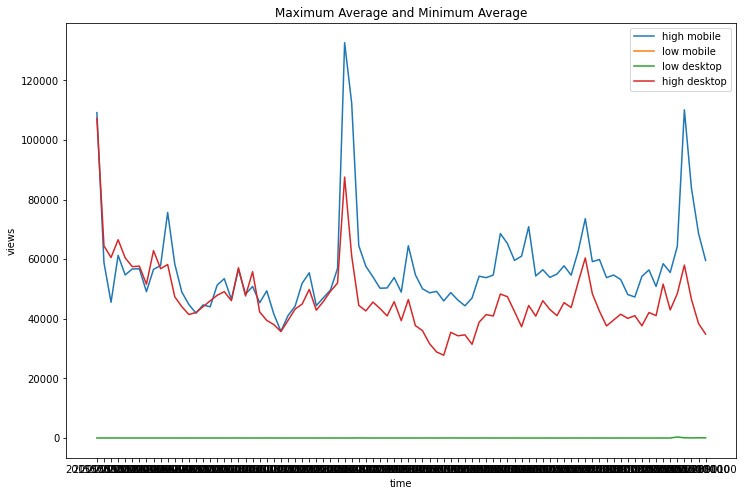

In [286]:
#Plot Maximum Average and Minimum Average
import matplotlib.pyplot as plt
def max_min_average(df_mobile, df_desk):
    
    df_mobile = pd.concat([df_web, df_app])

    df_mobile = df_mobile[df_mobile['article'] == 'Tyrannosaurus']
    df_mobile = df_mobile_t.drop_duplicates('timestamp')

#     df_mobile['timestamp'] = df_mobile['timestamp'].str.slice(0,6)
#     df_desk['timestamp'] = df_desk['timestamp'].str.slice(0,6)
    df_desk

    plt.plot(df_mobile['timestamp'][df_mobile['article'] == 'Tyrannosaurus'], df_mobile['views'][df_mobile['article'] == 'Tyrannosaurus'], label = 'high mobile')
    plt.plot(df_mobile['timestamp'][df_mobile['article'] == 'Honghesaurus'], df_mobile['views'][df_mobile['article'] == 'Honghesaurus'], label = 'low mobile')
    plt.plot(df_desk['timestamp'][df_desk['article'] == 'Honghesaurus'], df_desk['views'][df_desk['article'] == 'Honghesaurus'], label = 'low desktop')
    plt.plot(df_desk['timestamp'][df_desk['article'] == 'Tyrannosaurus'], df_desk['views'][df_desk['article'] == 'Tyrannosaurus'], label = 'high desktop')
    plt.legend()
    plt.xlabel('time')
    plt.ylabel('views')
#     plt.tight_layout()
#     ax = plt.gca()
#     plt.draw()
    plt.title('Maximum Average and Minimum Average')
#     ax.set_xticklabels(ax.get_xticks(), rotation = 45)
    plt.show()
    
max_min_average(df_mobile, df_desk)

In [310]:
#Top 10 Peak Page Views
def top_10_peak_page_views(df):
#     df['timestamp'] = df['timestamp'].str.slice(4,6)
    df = df.sort_values('views', ascending=False)
    df = df.drop_duplicates('article')
    df = df.drop_duplicates('timestamp')
    return df.head(10)

#Get list of the top 10 monthly desktop dinosaurs
top_10_peak_page_views(df_desk)


,project,article,granularity,timestamp,access,agent,views
67,en.wikipedia,Achelousaurus,monthly,2021020100,desktop,user,205150
0,en.wikipedia,Velociraptor,monthly,2015070100,desktop,user,135741
0,en.wikipedia,Halszkaraptor,monthly,2017120100,desktop,user,103251
83,en.wikipedia,Giganotosaurus,monthly,2022060100,desktop,user,62340
59,en.wikipedia,Lythronax,monthly,2020060100,desktop,user,57701
55,en.wikipedia,Nigersaurus,monthly,2020020100,desktop,user,57192
25,en.wikipedia,Borealopelta,monthly,2019090100,desktop,user,53831
35,en.wikipedia,Dilophosaurus,monthly,2018060100,desktop,user,53278
2,en.wikipedia,Stegosaurus,monthly,2015090100,desktop,user,49705
70,en.wikipedia,Deinocheirus,monthly,2021050100,desktop,user,49309


In [324]:
#Get list of the top 10 monthly mobile dinosaurs
df_mobile = pd.concat([df_web, df_app])
top_10_peak_page_views(df_mobile)

,project,article,granularity,timestamp,access,agent,views
55,en.wikipedia,Nigersaurus,monthly,2020020100,mobile-web,user,233924
70,en.wikipedia,Deinocheirus,monthly,2021050100,mobile-web,user,228922
83,en.wikipedia,Giganotosaurus,monthly,2022060100,mobile-web,user,154393
68,en.wikipedia,Achelousaurus,monthly,2021030100,mobile-web,user,140414
0,en.wikipedia,Velociraptor,monthly,2015070100,mobile-web,user,137803
35,en.wikipedia,Tyrannosaurus,monthly,2018060100,mobile-web,user,132621
25,en.wikipedia,Borealopelta,monthly,2019090100,mobile-web,user,115782
17,en.wikipedia,Argentinosaurus,monthly,2016120100,mobile-web,user,78020
36,en.wikipedia,Spinosaurus,monthly,2018070100,mobile-web,user,71739
60,en.wikipedia,Brontosaurus,monthly,2020070100,mobile-web,user,68908


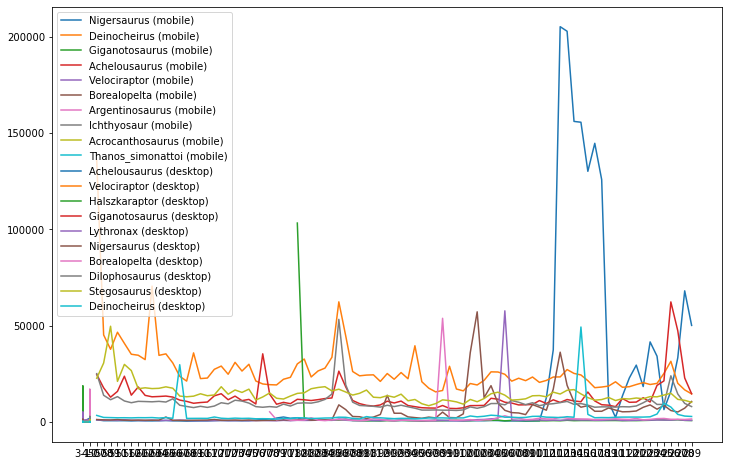

In [308]:
#Plot Top 10 Peak Page Views

def add_plot(df, name, label=None):
    df = df[df['article'] == name]
    df = df.drop_duplicates('timestamp')
    df['timestamp'] = df['timestamp'].astype(str).str.slice(3,6)
    return plt.plot(df['timestamp'], df['views'], label = label)

fig = plt.figure()

# plt.rcParams["figure.figsize"] = (12,8)
add_plot(df_mobile, 'Nigersaurus', label = 'Nigersaurus (mobile)')
add_plot(df_mobile, 'Deinocheirus', label = 'Deinocheirus (mobile)')
add_plot(df_mobile, 'Giganotosaurus', label = 'Giganotosaurus (mobile)')
add_plot(df_mobile, 'Achelousaurus', label = 'Achelousaurus (mobile)')
add_plot(df_mobile, 'Velociraptor', label = 'Velociraptor (mobile)')
add_plot(df_mobile, 'Borealopelta', label = 'Borealopelta (mobile)')
add_plot(df_mobile, 'Argentinosaurus', label = 'Argentinosaurus (mobile)')
add_plot(df_mobile, 'Ichthyosaur', label = 'Ichthyosaur (mobile)')
add_plot(df_mobile, 'Acrocanthosaurus' , label = 'Acrocanthosaurus (mobile)')
add_plot(df_mobile, 'Thanos_simonattoi', label = 'Thanos_simonattoi (mobile)')
add_plot(df_desk, 'Achelousaurus', label = 'Achelousaurus (desktop)')
add_plot(df_desk, 'Velociraptor', label = 'Velociraptor (desktop)')
add_plot(df_desk, 'Halszkaraptor', label = 'Halszkaraptor (desktop)')
add_plot(df_desk, 'Giganotosaurus', label = 'Giganotosaurus (desktop)')
add_plot(df_desk, 'Lythronax', label = 'Lythronax (desktop)')
add_plot(df_desk, 'Nigersaurus', label = 'Nigersaurus (desktop)')
add_plot(df_desk, 'Borealopelta', label = 'Borealopelta (desktop)')
add_plot(df_desk, 'Dilophosaurus', label = 'Dilophosaurus (desktop)')
add_plot(df_desk, 'Stegosaurus', label = 'Stegosaurus (desktop)')
add_plot(df_desk, 'Deinocheirus', label = 'Deinocheirus (desktop)')

plt.legend()

TypeError: can only concatenate str (not "int") to str

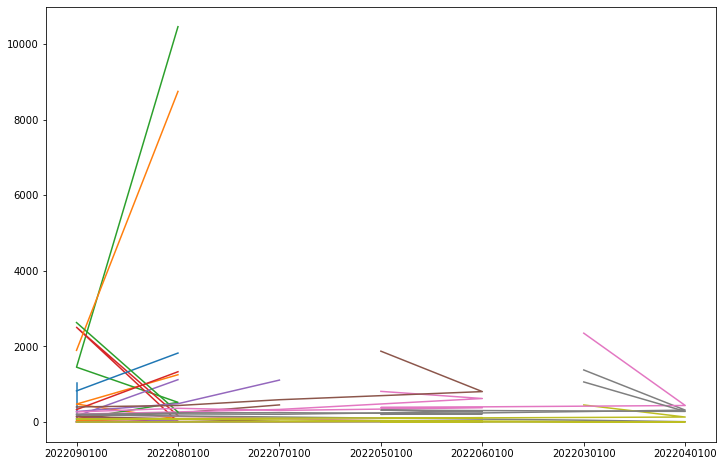

In [337]:
#Fewest months of data
import numpy as np
def fewest_months(df):
    d = {}
    for article in df['article']:
        if article not in d:
            d[article] = 1
        else:
            d[article] += 1
    sorted_d = sorted(d.items(), key=lambda kv: kv[1])
    return sorted_d[1:10]



def plot_fewest_months():
    mobile_d = fewest_months(df_mobile)
    desktop_d = fewest_months(df_desk)
    
    for key, value in mobile_d:
        temp_df = df_mobile[df_mobile['article'] == key]
        plt.plot(temp_df['timestamp'], temp_df['views'], label = key + "(mobile)")
    for key, value in desktop_d:
        temp_df = df_desk[df_desk['article'] == key]
        plt.plot(temp_df['timestamp'], temp_df['views'], label = key + "(desktop)")
    plt.xticks(np.arange(min(temp_df['timestamp']), max(temp_df['timestamp'])+1, 1.0))
    plt.legend()
    plt.show()
plot_fewest_months()

In [326]:
df_desk[df_desk['article'] =='Tuebingosaurus']

,project,article,granularity,timestamp,access,agent,views
0,en.wikipedia,Tuebingosaurus,monthly,2022090100,desktop,user,1423
